In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
#|default_exp gaussian_renderer

# Gaussian Renderer

In [37]:
#|export
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from functools import partial
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.math import lambertw

normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf
inv = jnp.linalg.inv

key = jax.random.PRNGKey(0)

In [38]:
import traceviz.client
from traceviz.proto import  viz_pb2
import json
import inspect
from IPython.display import Markdown as md
from bayes3d._mkl.plotting import *

In [39]:
#|export
from typing import Any, NamedTuple
import jaxlib


Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
Bool = Array
Float = Array
Int = Array
FaceIndex = int
FaceIndices = Array
ArrayN      = Array
Array3      = Array
Array2      = Array
ArrayNx2    = Array
ArrayNx3    = Array
Matrix      = jaxlib.xla_extension.ArrayImpl
PrecisionMatrix  = Matrix
CovarianceMatrix = Matrix
CholeskyMatrix   = Matrix
SquareMatrix     = Matrix
Vector     = Array
Direction  = Vector
BaseVector = Vector

In [40]:
#|export
def ellipsoid_embedding(cov:CovarianceMatrix) -> Matrix:
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ jnp.linalg.inv(U)

In [41]:
#|export
def bilinear(x:Array, y:Array, A:Matrix) -> Float:
    return x.T @ A @ y

In [42]:
#|export
def log_gaussian(x:Vector, mu:Vector, P:PrecisionMatrix) -> Float:
    """Evaluate an **unnormalized** gaussian at a given point."""
    return -0.5 * bilinear(x-mu, x-mu, P)


def gaussian(x:Vector, mu:Vector, P:PrecisionMatrix) -> Float:
    """Evaluate an **unnormalized** gaussian at a given point."""
    return jnp.exp(-0.5 * bilinear(x-mu, x-mu, P))


def gaussian_normalizing_constant(P:PrecisionMatrix) -> Float:
    """Returns the normalizing constant of an unnormalized gaussian."""
    n = P.shape[0]
    return jnp.sqrt(jnp.linalg.det(P)/(2*jnp.pi)**n)

In [87]:
#|export
def gaussian_restriction_to_ray(loc:Vector, P:PrecisionMatrix, A:CholeskyMatrix, x:Vector, v:Direction):
    """
    Restricts a gaussian to a ray and returns 
    the mean `mu` and standard deviation `std`, s.t. we have 
    $$
        P(x + t*v | loc, cov) = P(x + mu*v | loc, cov) * N(t | mu, std)
    $$
    """
    mu  = bilinear(loc - x, v, P)/bilinear(v, v, P)
    std = 1/jnp.linalg.norm(inv(A)@v)
    return mu, std

## Time of first arrival

In [46]:
#|export
def discrete_arrival_probabilities(occupancy_probs:Vector):
    """
    Given an vector of `n` occupancy probabilities of neighbouring pixels, 
    it returns a vector of length `n+1` containing the probabilities of stopping 
    at a each pixel (while traversing them left to right) or not stopping at all.

    The return array is given by:
    $$
        q_i = p_i \cdot \prod_{j=0}^{i-1} (1 - p_j)
        
    $$
    for $i=0,...,n-1$, and
    $$
        q_n = \prod_{j=1}^{n-1} (1 - p_j) = 1 - \sum_{i=0}^{n-1} q_i.
    $$

    This is basically the discrete version of time of first arrival $X$ for an imhomogenous poisson processes
    with rate function $\sigma(t)$:
    $$
        X(T) = \sigma(T)*\exp(- \int_0^T \sigma(t) \ dt).
    $$
    """
    transmittances       = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1-occupancy_probs)])
    extended_occupancies = jnp.concatenate([occupancy_probs, jnp.array([1.0])])
    return extended_occupancies * transmittances

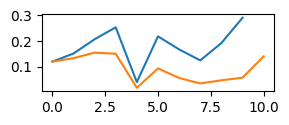

In [70]:
key = keysplit(key)
occupancy_probs = 0.3*jax.random.uniform(key, (10,))
arrival_probs   = discrete_arrival_probabilities(occupancy_probs)

assert jnp.isclose(arrival_probs.sum(), 1.0)

# =======================
plt.figure(figsize=(3,1))
plt.plot(jnp.arange(len(occupancy_probs)), occupancy_probs)
plt.plot(jnp.arange(len(occupancy_probs)+1), arrival_probs);

In [72]:
#|export
def gaussian_time_of_arrival(xs, mu, sig, w=1.0):
    """
    Time of first arrival for a **single** weighted 1-dimensional Gaussian, i.e. returns an array of
    with entries
    $$
        Y(T) = w*g(T | \mu, \sigma)*\exp(- \int_0^T w*g(t | \mu, \sigma) \ dt).
    $$
    """
    ys = w*normal_pdf(xs, loc=mu, scale=sig) * jnp.exp(
            - w*normal_cdf(xs, loc=mu, scale=sig) 
            + w*normal_cdf(0.0, loc=mu, scale=sig))
    return ys 


def gaussian_most_likely_time_of_arrival(mu, sig, w=1.):
    """
    Returns the most likely time of first arrival
    for a single weighted 1-dimensional Gaussian, i.e. the argmax of 
    $$
        Y(T) = w*g(T | \mu, \sigma)*\exp(- \int_0^T w*g(t | \mu, \sigma) \ dt).
    $$
    """
    # TODO: Check if this is correct, cf. my notes.
    Z = jnp.sqrt(lambertw(1/(2*jnp.pi) * w**2))
    return mu - Z*sig


    mu:  3.988
    sig: 1.680
    w:   0.906  
    t:   3.415



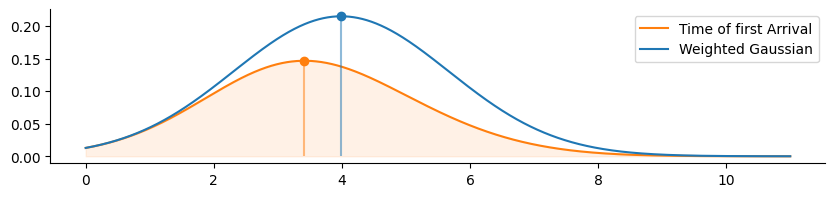

In [77]:
key, keys = keysplit(key,1,3)

xs = jnp.linspace(0,11,20_000)
mu  = jax.random.uniform(keys[0],(), float, 3.0,8.0)
sig = jax.random.uniform(keys[1],(), float, 0.1,2.0)
w   = jax.random.uniform(keys[2],(), float, 0.1,1.0)
t   = gaussian_most_likely_time_of_arrival(mu, sig, w=w)

print(f"""
    mu:  {mu:0.3f}
    sig: {sig:0.3f}
    w:   {w:0.3f}  
    t:   {t:0.3f}
""")

# =======================
plt.figure(figsize=(10,2))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(xs, gaussian_time_of_arrival(xs, mu, sig, w), c="C1", alpha=1., label="Time of first Arrival")
plt.fill_between(xs, gaussian_time_of_arrival(xs, mu, sig, w), color="C1", alpha=0.1)
plt.vlines(t, 0, gaussian_time_of_arrival(t, mu, sig, w), color="C1", alpha=.5)
plt.scatter(t, gaussian_time_of_arrival(t, mu, sig, w), c="C1")
plt.plot(xs, w*normal_pdf(xs, loc=mu, scale=sig), c="C0", alpha=1., label="Weighted Gaussian")
plt.vlines(mu, 0, w*normal_pdf(mu, loc=mu, scale=sig), color="C0", alpha=.5)
plt.scatter(mu, w*normal_pdf(mu, loc=mu, scale=sig), c="C0")
plt.legend();

## Fuzzy Intersections

In [138]:
#|export
def weighted_arrival_intersection(mu:Vector, P:PrecisionMatrix, A:CholeskyMatrix, w:Float, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t0, sig0 = gaussian_restriction_to_ray(mu, P, A, x, v)
    w0 = w*gaussian(t0*v, mu, P)
    Z = w0/gaussian_normalizing_constant(P)
    t = gaussian_most_likely_time_of_arrival(t0, sig0, Z)
    return t, w0

In [242]:
#|export
def argmax_intersection(mu:Vector, P:PrecisionMatrix, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t = bilinear(mu - x, v, P)/bilinear(v, v, P)
    return t


#|export
def weighted_argmax_intersection(mu:Vector, P:PrecisionMatrix, w:Float, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t = bilinear(mu - x, v, P)/bilinear(v, v, P)
    return t, w*gaussian(x + t*v, mu, P)

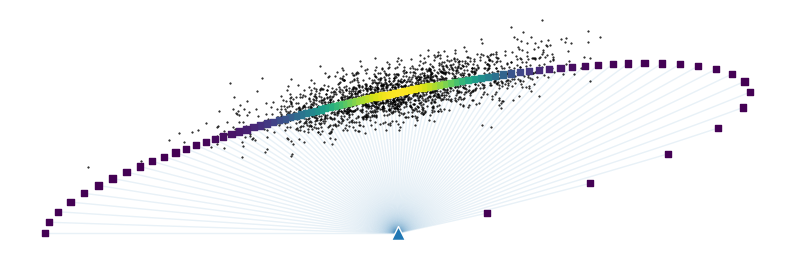

In [243]:
# Define Gaussian
A   = jnp.array([[5,1],[0,1]]).T 
loc = jnp.array([0.,10.])
w   = 1.
Cov = A@A.T 
P   = inv(Cov)

# Gaussian samples
key = keysplit(key)
xs = jax.random.normal(key, shape=(2_000,2)) 
ys = xs@A.T + loc

# Ray directions
n = 100
ths = jnp.linspace(0, jnp.pi, n); # "Thetas"
vs  = jnp.stack([jnp.cos(ths), jnp.sin(ths)], axis=1)

# Intersection points
# Try both verions:
# ts, ps = vmap(weighted_arrival_intersection, (None,None,None,None,None,0))(loc, P, A, w, jnp.zeros(2), vs)
ts, ps = vmap(weighted_argmax_intersection, (None,None,None,None,0))(loc, P, w, jnp.zeros(2), vs)
zs = ts[:,None]*vs 
valid = ts > 0



# ============================ 
fig, ax = plt.subplots(1,1, figsize=(10,4))
axs = [ax]
axs[0].axis('off')
axs[0].set_aspect('equal')
axs[0].scatter(*ys[:].T, s=1., alpha=1., c="k", marker=".")
axs[0].scatter(*zs[valid].T, s=20, c=ps[valid], cmap="viridis", marker="s",alpha=1)
plot_segs(jnp.concatenate([jnp.zeros((n,2)), zs], axis=-1)[valid], ax=axs[0], alpha=0.1, c="C0", zorder=0)
axs[0].scatter(0,0,c="C0", marker="^",s=100, edgecolor="w", zorder=1);

In [22]:
gaussian?

Signature: gaussian(x, mu, P: jaxlib.xla_extension.ArrayImpl)
Docstring: Evaluate an **unnormalized** gaussian at a given point.
File:      /var/tmp/ipykernel_200170/2728436224.py
Type:      function

(2, 100) (100, 3)
[2.319523e-16 3.783506e-44]
[2.319523e-16 3.783506e-44 1.000000e+00]
(2, 100)


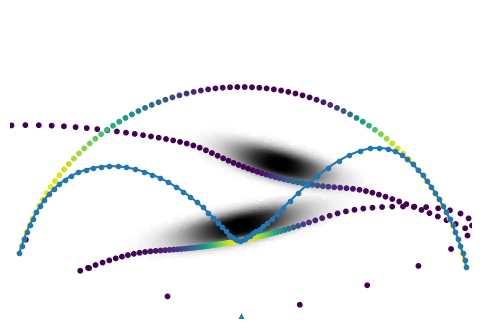

In [144]:
A1   = jnp.array([[5,1],[0,1]]).T 
loc1 = jnp.array([0.,12.])
w1= 1.
A2   = jnp.array([[4,-1],[0,1]]).T 
loc2 = jnp.array([5.,20.])
w2= 1.

ps = []
ts = []
ys = []
cs = []
n = 100
ths = jnp.linspace(0, jnp.pi, n)
vs = jnp.stack([jnp.cos(ths), jnp.sin(ths)], axis=1)
for A, loc,w in [(A1,loc1,w1), (A2,loc2,w2)]: 
    key = keysplit(key)
    Cov = A@A.T 
    P   = inv(Cov)

    xs = jax.random.normal(key, shape=(5_000,2)) 
    ys_ = xs@A.T + loc
    cs_ = vmap(lambda y: w*gaussian(y, loc, P))(ys_)
    order = jnp.argsort(cs_)
    ys.append(ys_[order])
    cs.append(cs_[order])
    ts_, ps_ = vmap(weighted_arrival_intersection, (None,None,None,None,None,0))(loc, P, A, w, jnp.zeros(2), vs)
    # ts_, ps_ = vmap(weighted_argmax_intersection, (None,None,None,None,0))(loc, P, w, jnp.zeros(2), vs)
    ts.append(ts_)
    ps.append(ps_)

ps = jnp.array(ps)
ts = jnp.array(ts)
ys = jnp.array(ys)
cs = jnp.array(cs)
zs = ts[:,:,None]*vs[None]
qs = vmap(discrete_arrival_probabilities)(ps.T)
valid = ts > 0
print(ps.shape, qs.shape)
print(ps[:,0])
print(qs[0])
print(valid.shape)

zmax=30
ds = qs.T[0]*ts[0] + qs.T[1]*ts[1]  + qs.T[2]*zmax
ds = ds[:,None]*vs

all_valid =valid[1]*valid[0]

ys_all = jnp.concatenate(ys)
cs_all = jnp.concatenate(cs)
order_all = jnp.argsort(cs_all)
ys_all = ys_all[order_all]  
cs_all = cs_all[order_all]

# =========================================
s_inter = 10

fig, ax = plt.subplots(1,1, figsize=(10,4))
axs = [ax]
axs[0].set_xlim(-30,30)
axs[0].set_ylim(0, 40)
axs[0].axis('off')
axs[0].set_aspect('equal')
axs[0].scatter(0,0,c="C0", marker="^",s=100, edgecolor="w", zorder=1)
# axs[0].scatter(*ys[0].T, s=10, c=np.clip(1-w1,0.3,0.7)*np.array([[1,1,1]]), edgecolor=np.clip(1-10*w1,0,1)*np.array([[1,1,1]]), linewidth=0.1, marker="o")
# axs[0].scatter(*ys[1].T, s=10, c=np.clip(1-w2,0.3,0.7)*np.array([[1,1,1]]), edgecolor=np.clip(1-10*w2,0,1)*np.array([[1,1,1]]), linewidth=0.1, marker="o")
# axs[0].scatter(*ys[0].T, s=30, c=cs[0], vmin=0, vmax=1, cmap="binary", marker="o")
# axs[0].scatter(*ys[1].T, s=30, c=cs[1], vmin=0, vmax=1, cmap="binary", marker="o")
axs[0].scatter(*ys_all.T, s=30, c=cs_all, vmin=0, vmax=1, cmap="binary", marker="o")
axs[0].scatter(*zs[0,all_valid].T, s=s_inter, c=qs[all_valid,0], cmap="viridis", vmin=qs.min(), vmax=qs.max(), marker="o",alpha=1)
axs[0].scatter(*zs[1,all_valid].T, s=s_inter, c=qs[all_valid,1], cmap="viridis", vmin=qs.min(), vmax=qs.max(), marker="o",alpha=1);

# axs[0].scatter(*ds[all_valid].T, s=20, c=qs[valid[1]*valid[0],2], vmin=qs.min(), vmax=qs.max(), marker="s",alpha=1);
axs[0].scatter(*(zmax * vs)[all_valid].T, s=s_inter, c=qs[valid[1]*valid[0],2], vmin=qs.min(), vmax=qs.max(), marker="o", alpha=1);
axs[0].plot(*ds[all_valid].T, marker=".", c="C0");


In [145]:
%matplotlib inline
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, HTMLMath, HTML,
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')



def func(w1, w2):
    global key;
    A1   = jnp.array([[5,1],[0,1]]).T 
    loc1 = jnp.array([0.,12.])

    A2   = jnp.array([[4,-1],[0,1]]).T 
    loc2 = jnp.array([5.,20.])


    ps = []
    ts = []
    ys = []
    cs = []
    n = 100
    ths = jnp.linspace(0, jnp.pi, n)
    vs = jnp.stack([jnp.cos(ths), jnp.sin(ths)], axis=1)
    for A, loc,w in [(A1,loc1,w1), (A2,loc2,w2)]: 
        key = keysplit(key)
        Cov = A@A.T 
        P   = inv(Cov)

        xs = jax.random.normal(key, shape=(5_000,2)) 
        ys_ = xs@A.T + loc
        cs_ = vmap(lambda y: w*gaussian(y, loc, P))(ys_)
        order = jnp.argsort(cs_)
        ys.append(ys_[order])
        cs.append(cs_[order])
        ts_, ps_ = vmap(arrival_intersection, (None,None,None,None,None,0))(loc, P, A, w, jnp.zeros(2), vs)
        ts.append(ts_)
        ps.append(ps_)

    ps = jnp.array(ps)
    ts = jnp.array(ts)
    ys = jnp.array(ys)
    cs = jnp.array(cs)
    zs = ts[:,:,None]*vs[None]
    qs = vmap(discrete_arrival_probabilities)(ps.T)
    valid = ts > 0


    zmax=30
    ds = qs.T[0]*ts[0] + qs.T[1]*ts[1]  + qs.T[2]*zmax
    ds = ds[:,None]*vs

    all_valid =valid[1]*valid[0]

    ys_all = jnp.concatenate(ys)
    cs_all = jnp.concatenate(cs)
    order_all = jnp.argsort(cs_all)
    ys_all = ys_all[order_all]  
    cs_all = cs_all[order_all]

    # =========================================
    s_inter = 10

    fig, ax = plt.subplots(1,1, figsize=(10,4))
    axs = [ax]
    axs[0].set_xlim(-30,30)
    axs[0].set_ylim(0, 40)
    axs[0].axis('off')
    axs[0].set_aspect('equal')
    axs[0].scatter(0,0,c="C0", marker="^",s=100, edgecolor="w", zorder=1)
    # axs[0].scatter(*ys[0].T, s=10, c=np.clip(1-w1,0.3,0.7)*np.array([[1,1,1]]), edgecolor=np.clip(1-10*w1,0,1)*np.array([[1,1,1]]), linewidth=0.1, marker="o")
    # axs[0].scatter(*ys[1].T, s=10, c=np.clip(1-w2,0.3,0.7)*np.array([[1,1,1]]), edgecolor=np.clip(1-10*w2,0,1)*np.array([[1,1,1]]), linewidth=0.1, marker="o")
    # axs[0].scatter(*ys[0].T, s=30, c=cs[0], vmin=0, vmax=1, cmap="binary", marker="o")
    # axs[0].scatter(*ys[1].T, s=30, c=cs[1], vmin=0, vmax=1, cmap="binary", marker="o")
    axs[0].scatter(*ys_all.T, s=30, c=cs_all, vmin=0, vmax=1, cmap="binary", marker="o")
    axs[0].scatter(*zs[0,all_valid].T, s=s_inter, c=qs[all_valid,0], cmap="viridis", vmin=qs.min(), vmax=qs.max(), marker="o",alpha=1)
    axs[0].scatter(*zs[1,all_valid].T, s=s_inter, c=qs[all_valid,1], cmap="viridis", vmin=qs.min(), vmax=qs.max(), marker="o",alpha=1);

    # axs[0].scatter(*ds[all_valid].T, s=20, c=qs[valid[1]*valid[0],2], vmin=qs.min(), vmax=qs.max(), marker="s",alpha=1);
    axs[0].scatter(*(zmax * vs)[all_valid].T, s=s_inter, c=qs[valid[1]*valid[0],2], vmin=qs.min(), vmax=qs.max(), marker="o", alpha=1);

    axs[0].plot(*ds[all_valid].T, c="C0", linestyle="-");


widget = interactive(func,
        w1 = FloatSlider(min=0.0, max=1., step=0.01, value=1.0, continuous_update=False, description='w1'),
        w2 = FloatSlider(min=0.0, max=1., step=0.01, value=1.0, continuous_update=False, description='w2')
)
widget

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='w1', max=1.0, step=0.01), F…

## Renderer - Casting Rays

In [279]:
THRESH_99 = gaussian(jnp.array([4,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_97 = gaussian(jnp.array([3,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_73 = gaussian(jnp.array([2,0,0]), jnp.zeros(3), jnp.eye(3))

In [458]:
#|export
def _cast_ray(v, mus, precisions, colors, weights, zmax=2.0, bg_color=jnp.array([1.,1.,1.,1.])):
    # TODO: Deal with negative intersections behind the camera
    # TODO: Maybe switch to log probs?

    # Compute fuzzy intersections `xs` with Gaussians and 
    # their function values `sigmas`
    ts, sigmas = vmap(weighted_argmax_intersection, (0,0,0,None,None))(
                        mus, precisions, weights, jnp.zeros(3), v)
    order  = jnp.argsort(ts)
    ts     = ts[order]
    sigmas = sigmas[order]
    xs     = ts[:,None]*v[None,:]

    # TODO: Ensure that alphas are in [0,1]
    # TODO: Should we reset the color opacity to `op`?
    # Alternatively we can set `alphas = (1 - jnp.exp(-sigmas*1.0))` -- cf. Fuzzy Metaballs paper
    alphas = sigmas * (ts > 0)
    arrival_probs = discrete_arrival_probabilities(alphas)
    op = 1 - arrival_probs[-1] # Opacity
    mean_depth = jnp.sum(arrival_probs[:-1]*xs[:,2]) \
                    + arrival_probs[-1]*zmax
    mean_color = jnp.sum(arrival_probs[:-1,None]*colors[order], axis=0) \
                    + arrival_probs[-1]*bg_color    

    return mean_depth, mean_color, op


cast_rays = jit(vmap(_cast_ray, (0,None,None,None,None,None,None)))

In [459]:
w = 100
h = 100
f = 300
intr = Intrinsics(width = w, height = h,fx = f, fy = f,
            cx = w/2 - 0.5, cy = h/2 - 0.5, near = 1e-6, far = 5.0)

cam_pose = transform_from_pos_target_up(0.7*jnp.array([1.,0,0.5]), jnp.array([0,0.03,0]), jnp.array([0,1,0]))
cam_K    = K_from_intrinsics(intr)
rays     = camera_rays_from_intrinsics(intr)

In [460]:
bit_to_mb   = 1.25e-7
bit_to_gb   = 1.25e-10
n_gaussians = 100

print(f"{w*h*n_gaussians * 32 * bit_to_gb} GB")

0.004 GB



780 of 1550 Gaussians have data associated to them.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


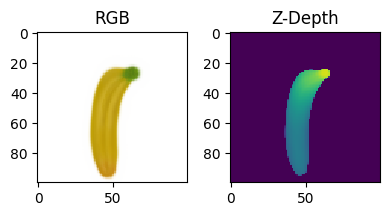

In [461]:
from sklearn.mixture import GaussianMixture


data = jnp.load('data/gaussians_banana_1550.npz')
valid  = data["nums"] > 0 
mus    = data["mus"][valid]
covs   = data["covs"][valid]
colors = data["mean_colors"][valid]

print(f"""
{jnp.sum(valid)} of {len(valid)} Gaussians have data associated to them.
""")

mus  = (mus - cam_pose[:3,3]) @ cam_pose[:3,:3] # same as mapping `mu -> inv(cam_pose) @ mu``
covs = vmap(lambda cov: cam_pose[:3,:3] @ cov @ cam_pose[:3,:3].T)(covs) 
precisions = vmap(inv)(2.**2*covs)
weights    = jnp.ones(len(mus))
zmax       = 5.0
bg_color  = jnp.array([1.,1.,1.,1.])


zs, cs, _ = cast_rays(rays.reshape(-1,3), mus, precisions, colors, weights, zmax, bg_color)
zs = zs.reshape(intr.height, intr.width)
cs = cs.reshape(intr.height, intr.width, -1)



gm = GaussianMixture(n_components=3).fit(zs.reshape(-1,1))
# ==============================
fig, axs = plt.subplots(1,2, figsize=(4,4))
axs[0].set_title("RGB")
axs[0].imshow(cs, interpolation="nearest")
axs[1].set_title("Z-Depth")
axs[1].imshow(zs, cmap="viridis_r", vmin=z_mean-3*np.sqrt(z_var), vmax=z_mean+3*np.sqrt(z_var), interpolation="nearest")
fig.tight_layout()

In [462]:
cloud = unproject_depth(zs[::-1,::-1], intr).reshape(-1,3)

In [464]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "spheres"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'centers': np.array(cloud), 
        'colors': np.array(cs[::-1,::-1].reshape(-1,4)), 
        "scales": 0.002*np.ones(len(cloud))
    })
)
    

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  
